# **Hackday 3° Edicao - Classificação**

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz

from sklearn.metrics       import mean_absolute_error, mean_squared_error, f1_score
from sklearn.ensemble      import RandomForestClassifier
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
import sklearn.model_selection as ms
from xgboost import XGBClassifier

%matplotlib inline
sns.set_theme()
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 500)
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 16

# 1.0. Data Collection

In [50]:
df1 = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [51]:
df1.head()

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp,limite_adicional
0,1767,21,278.17,2577.05,24196.90,104.31,31.04,6,5,7,21,14,9,15,Não,Não,Negar
1,11920,40,268.87,2465.39,19227.38,69.86,36.92,5,8,5,40,23,10,18,Não,Não,Negar
2,8910,36,446.64,1055.29,42822.28,134.20,34.56,0,3,6,26,13,3,15,Sim,Não,Negar
3,4964,58,321.14,703.05,51786.83,297.35,31.49,0,3,7,12,7,2,1,Sim,Não,Negar
4,10100,35,428.72,891.29,44626.85,134.20,28.03,2,8,7,24,10,8,20,Sim,Não,Negar


In [52]:
df1.shape

(9500, 17)

In [53]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9500 entries, 0 to 9499
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_cliente               9500 non-null   int64  
 1   idade                    9500 non-null   int64  
 2   saldo_atual              9500 non-null   float64
 3   divida_atual             9500 non-null   float64
 4   renda_anual              9500 non-null   float64
 5   valor_em_investimentos   9500 non-null   float64
 6   taxa_utilizacao_credito  9500 non-null   float64
 7   num_emprestimos          9500 non-null   int64  
 8   num_contas_bancarias     9500 non-null   int64  
 9   num_cartoes_credito      9500 non-null   int64  
 10  dias_atraso_dt_venc      9500 non-null   int64  
 11  num_pgtos_atrasados      9500 non-null   int64  
 12  num_consultas_credito    9500 non-null   int64  
 13  taxa_juros               9500 non-null   int64  
 14  investe_exterior        

## 1.1. Descriptive Statistics

In [54]:
num_attributes, cat_attributes = df1.select_dtypes( include=['int64', 'float64'] ), df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

#### Numerical Variables

In [55]:
desc_stats = pd.concat([num_attributes.describe(), pd.DataFrame([num_attributes.skew(), num_attributes.kurtosis()], index=['skew', 'kurtosis'])], axis=0).T
desc_stats

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
id_cliente,9500.00,6210.53,3603.24,1.00,3091.75,6172.50,9320.25,12500.00,0.01,-1.20
idade,9500.00,126.40,685.04,18.00,28.00,38.00,47.00,8598.00,9.09,87.61
saldo_atual,9500.00,404.53,217.70,0.09,272.36,337.17,471.26,1602.04,1.62,3.10
divida_atual,9500.00,1437.09,1156.26,0.23,573.62,1175.73,1963.33,4998.07,1.19,0.85
renda_anual,9500.00,195037.27,1454273.73,10473.87,26207.90,45991.11,80449.83,23279657.98,11.87,149.39
valor_em_investimentos,9500.00,612.00,2002.44,0.00,76.08,134.20,249.18,10000.00,4.44,17.87
taxa_utilizacao_credito,9500.00,32.27,5.11,20.99,28.08,32.26,36.46,49.56,0.04,-0.92
num_emprestimos,9500.00,10.86,62.56,0.00,2.00,3.00,6.00,1496.00,16.37,310.98
num_contas_bancarias,9500.00,17.55,120.98,0.00,3.00,6.00,7.00,1779.00,10.88,123.22
num_cartoes_credito,9500.00,21.43,122.68,1.00,4.00,6.00,7.00,1479.00,8.56,76.79


#### Categorical Variables

In [56]:
cat_attributes.apply( lambda x: x.nunique() )

investe_exterior    2
pessoa_polit_exp    2
limite_adicional    2
dtype: int64

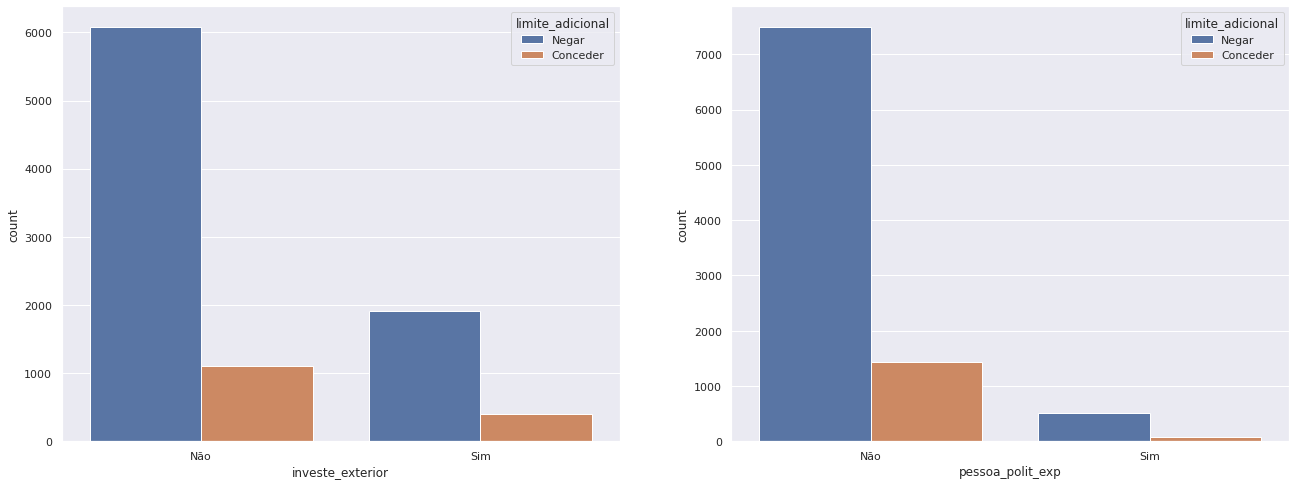

In [57]:
fig, ax  = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))

sns.countplot(x='investe_exterior', hue='limite_adicional', data=df1, ax=ax[0])
sns.countplot(x='pessoa_polit_exp', hue='limite_adicional', data=df1, ax=ax[1])

plt.show()

# 2.0. Feature Engineering

In [58]:
df2 = df1.copy()

In [59]:
df2['comprometimento_renda'] = df2[['divida_atual', 'renda_anual']].apply(lambda x: \
    (x['divida_atual']/x['renda_anual'])*100, axis=1)

df2['comprometimento_renda'] = df2['comprometimento_renda'].apply(lambda x: 'Não' if x < 30 else 'Sim')

df2['num_pgtos_atrasados'] = df1['num_pgtos_atrasados'].apply(lambda x: 'Excelente' if x == 0 else 'Bom'\
    if 1 <= x <= 10 else 'Regular' if 11 <= x <= 20 else 'Ruim')

In [60]:
for col in df2.columns:
    print(f"{col}: {df2[col].nunique()} --> {df2[col].dtype}")

id_cliente: 9500 --> int64
idade: 236 --> int64
saldo_atual: 9408 --> float64
divida_atual: 9330 --> float64
renda_anual: 9492 --> float64
valor_em_investimentos: 8623 --> float64
taxa_utilizacao_credito: 9500 --> float64
num_emprestimos: 58 --> int64
num_contas_bancarias: 132 --> int64
num_cartoes_credito: 205 --> int64
dias_atraso_dt_venc: 73 --> int64
num_pgtos_atrasados: 4 --> object
num_consultas_credito: 154 --> int64
taxa_juros: 205 --> int64
investe_exterior: 2 --> object
pessoa_polit_exp: 2 --> object
limite_adicional: 2 --> object
comprometimento_renda: 2 --> object


In [61]:
df2.shape

(9500, 18)

In [62]:
df2['limite_adicional'].unique()

array(['Negar', 'Conceder'], dtype=object)

Target Variable Encoding

In [63]:
map_target = {
    "Negar": 0,
    "Conceder": 1
}

df2["limite_adicional"] = df2["limite_adicional"].map(map_target)

#### Filtragem de Linhas

In [64]:
# df2 = df2.loc[df2['idade'] < 120, :]

In [65]:
def filter_outliers(df, col, factor=2):
    q3 = df[col].quantile(0.75)
    q1 = df[col].quantile(0.25)

    iqr = q3 - q1
    max_bouderie = q3 + iqr * factor
    min_bouderie = q1 - iqr * factor

    return df.loc[(df[col] >= min_bouderie) & (df[col] <= max_bouderie), :]


In [66]:
df2 = filter_outliers(df2, 'idade')
df2 = filter_outliers(df2, 'valor_em_investimentos')
df2 = filter_outliers(df2, 'taxa_juros')
df2 = filter_outliers(df2, 'renda_anual')
df2 = filter_outliers(df2, 'num_emprestimos')
df2 = filter_outliers(df2, 'num_cartoes_credito')
df2 = filter_outliers(df2, 'num_contas_bancarias')
df2 = filter_outliers(df2, 'num_consultas_credito')


# 3.0. Análise Exploratória de Dados

In [67]:
df3 = df2.copy()

## 3.1. Análise Univariada

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)



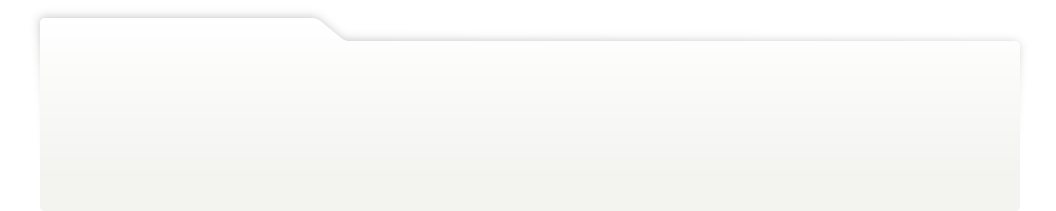
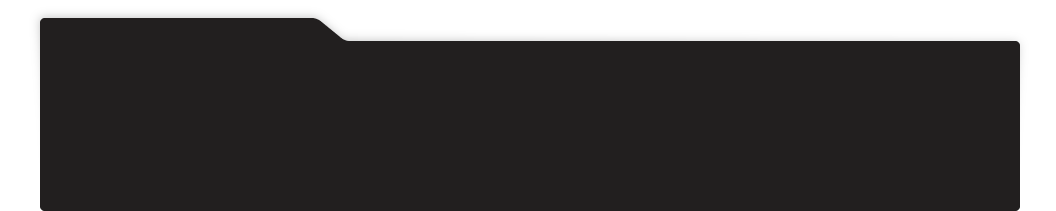
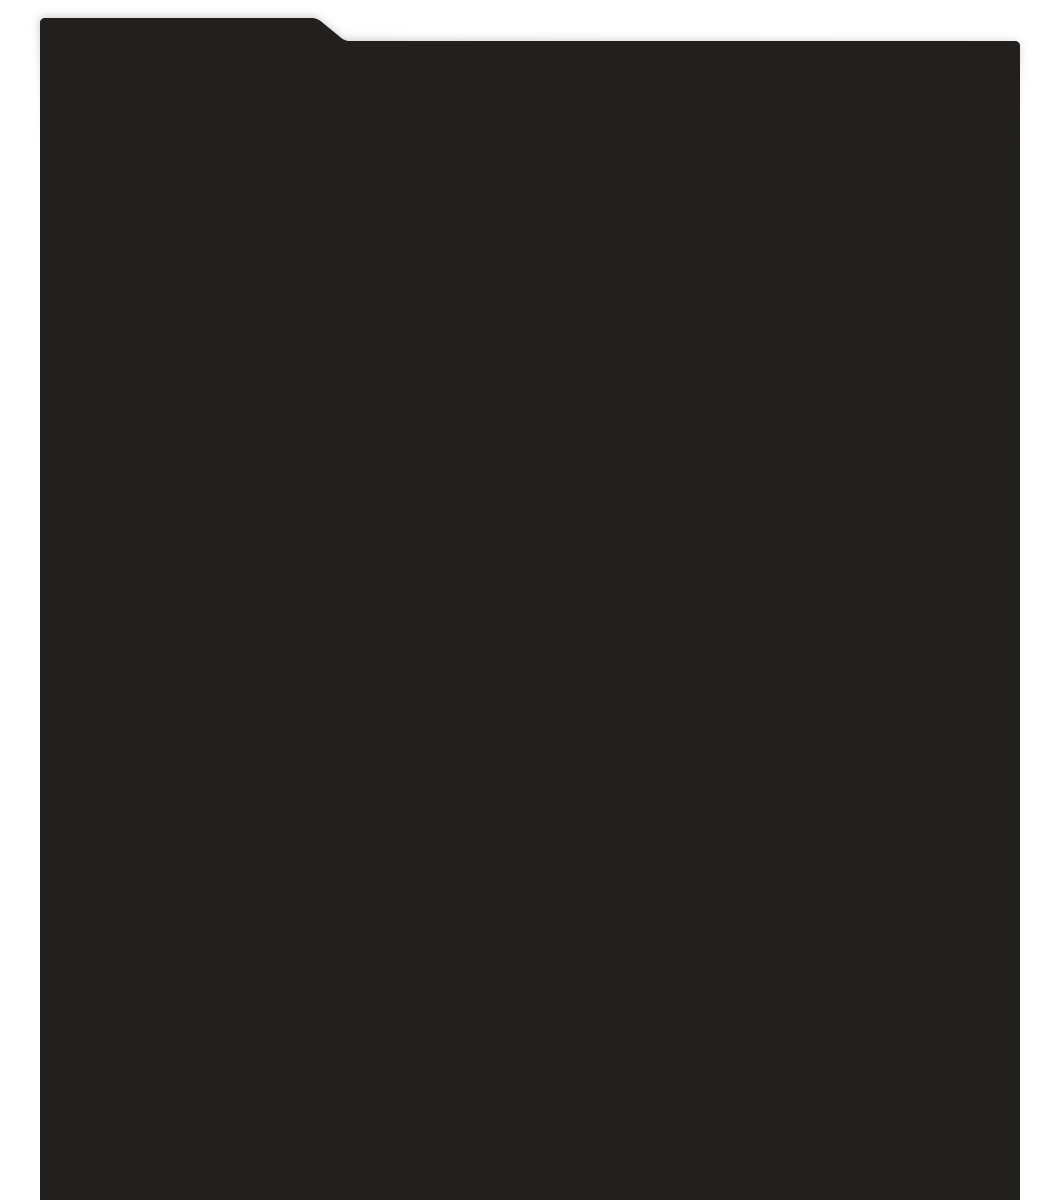
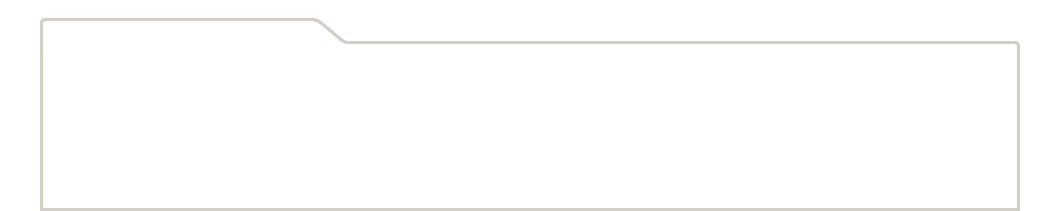
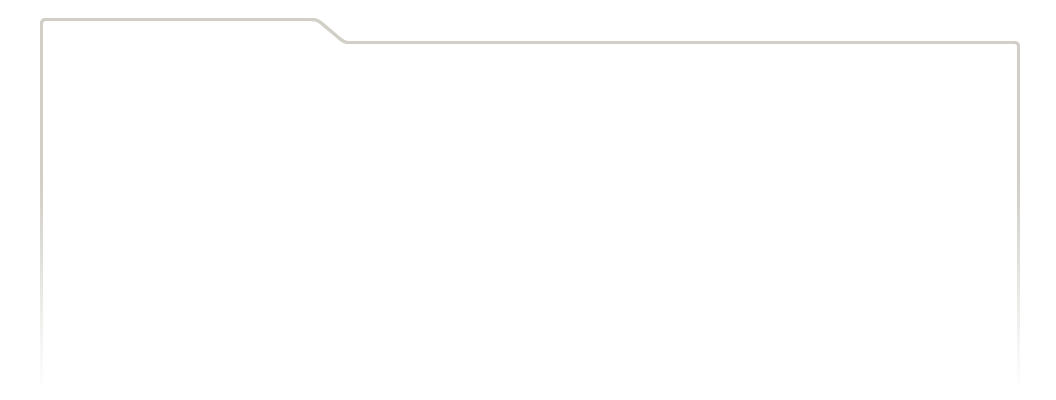
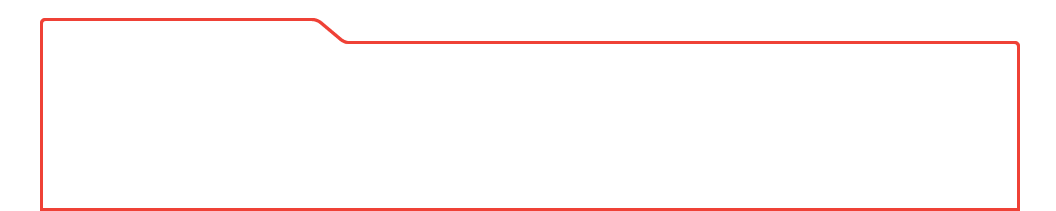
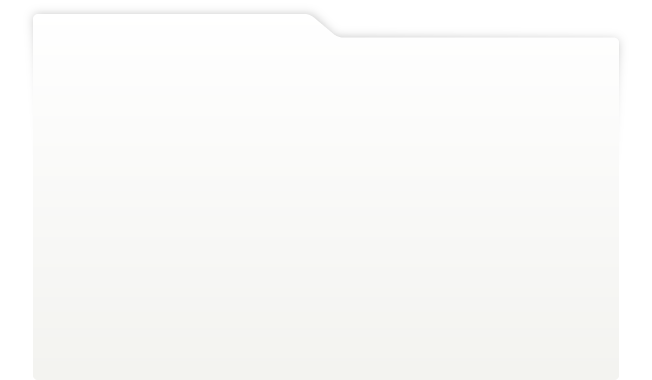
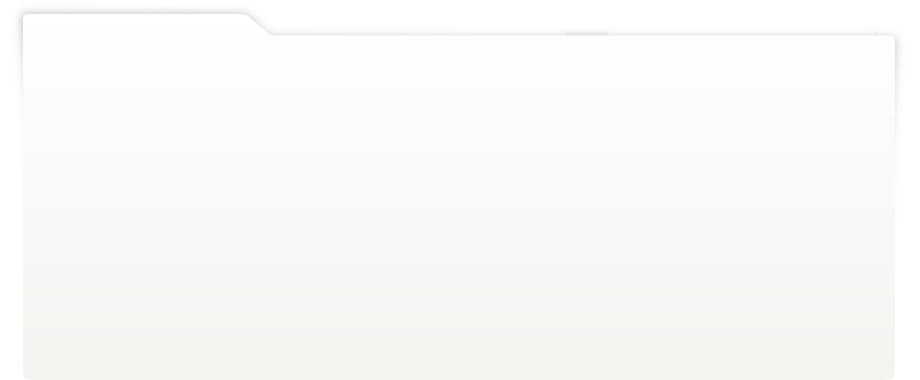
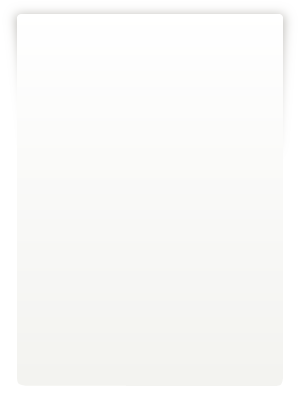
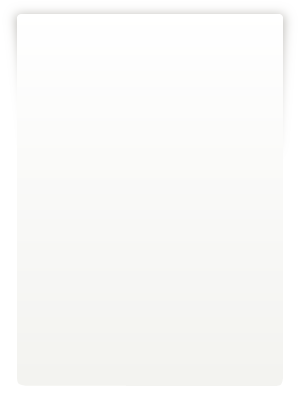
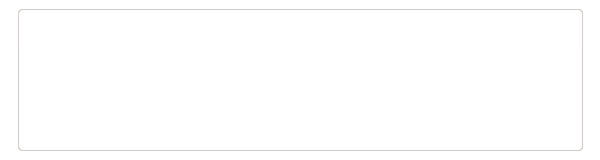
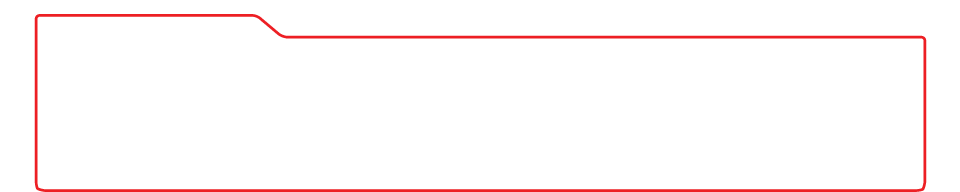
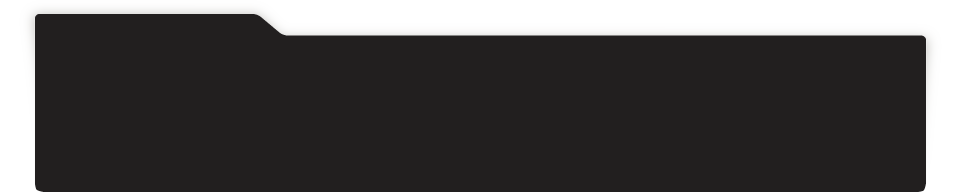
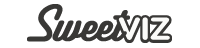
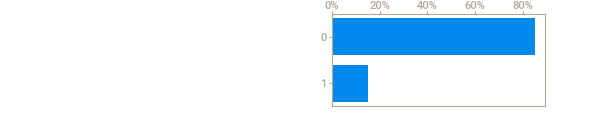
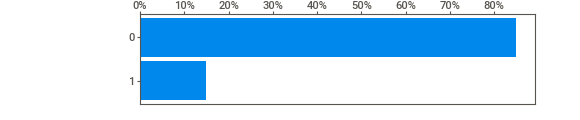
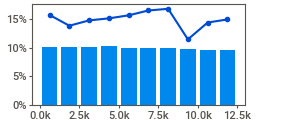
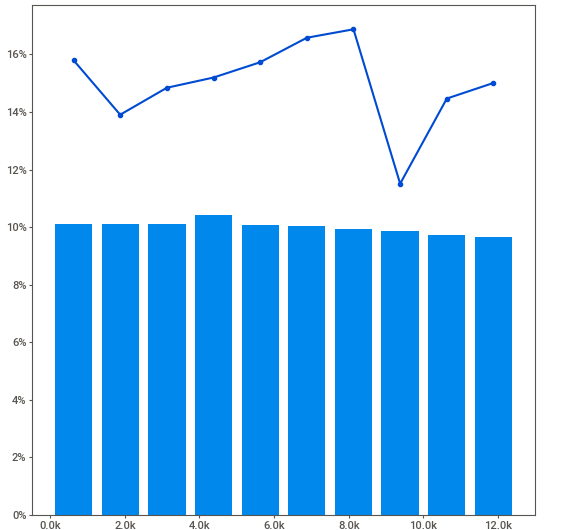
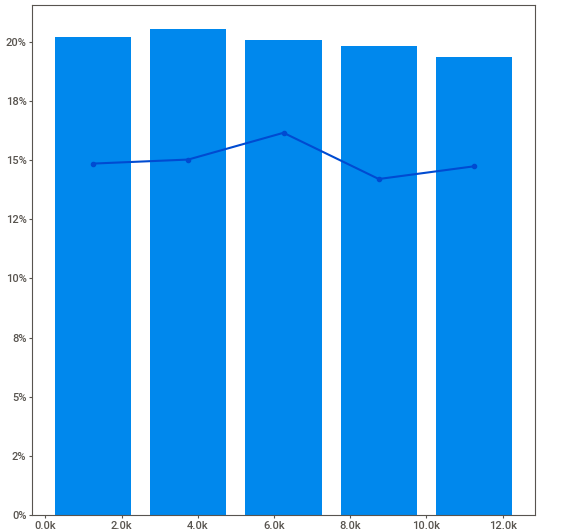
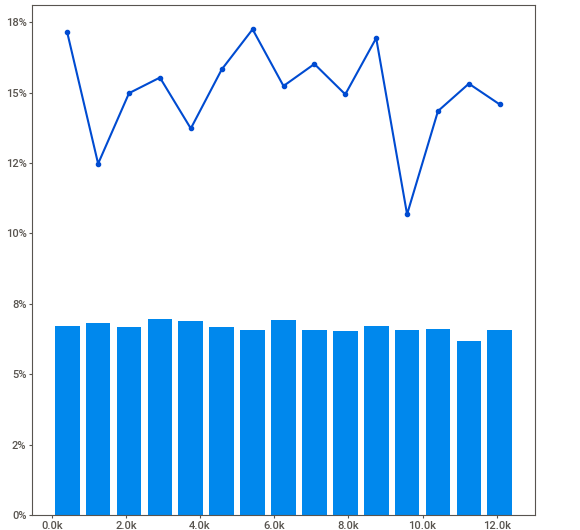
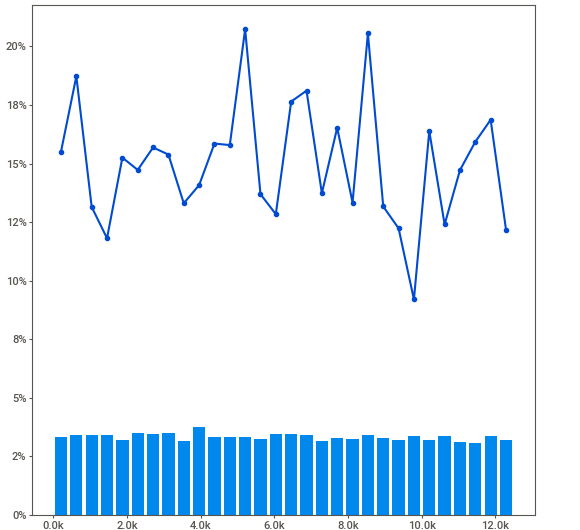
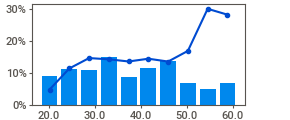
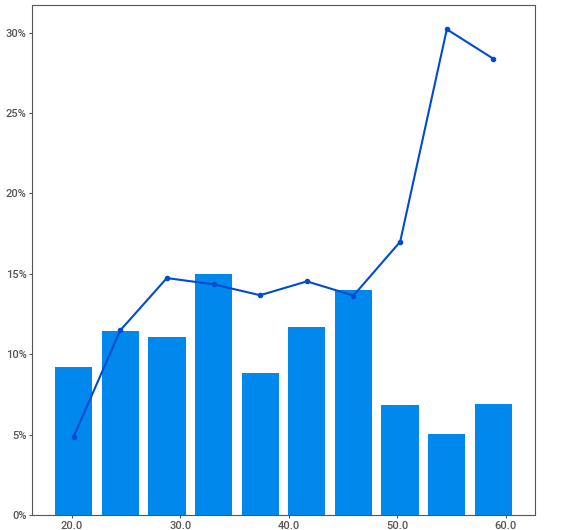
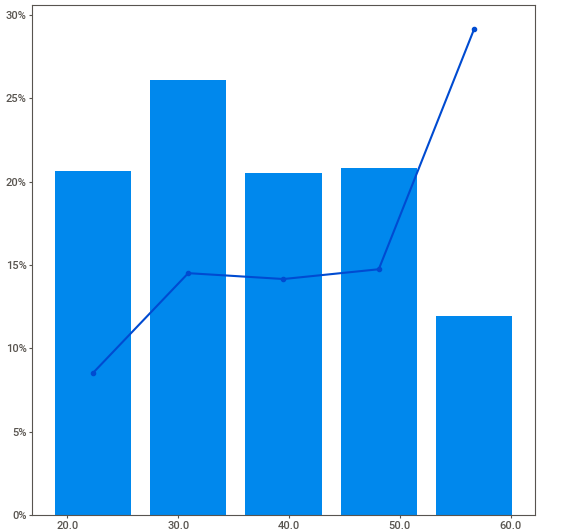
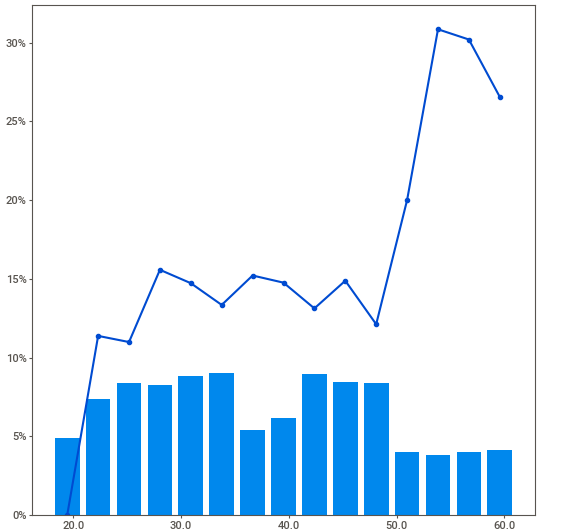
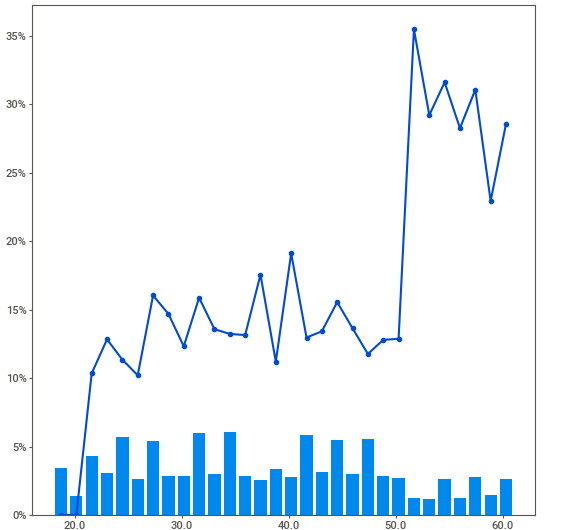
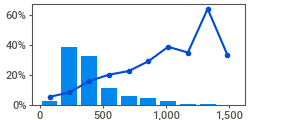
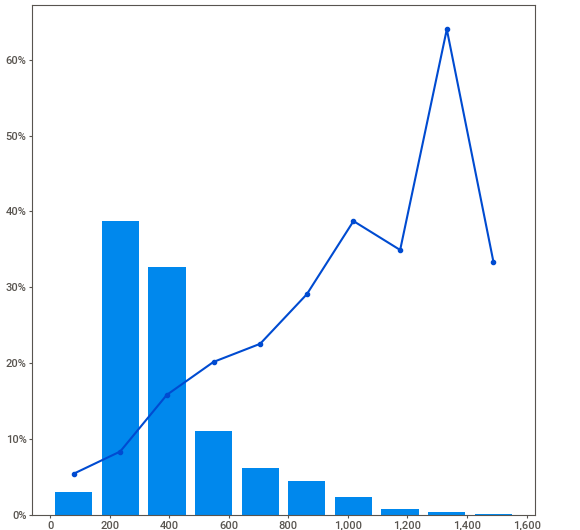
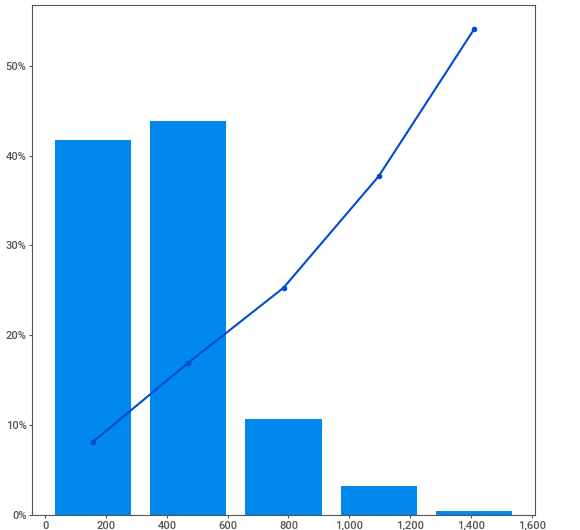
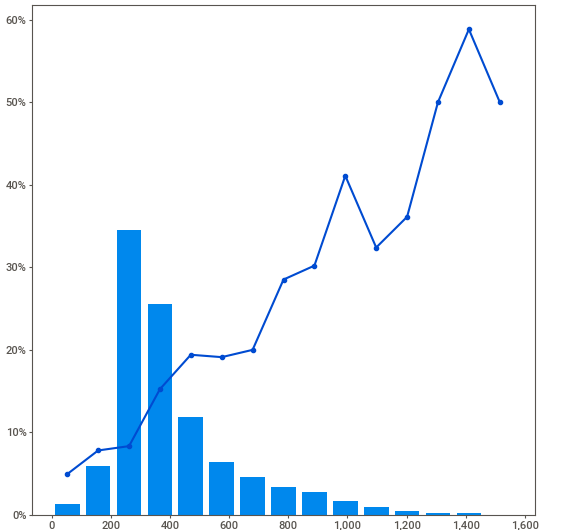
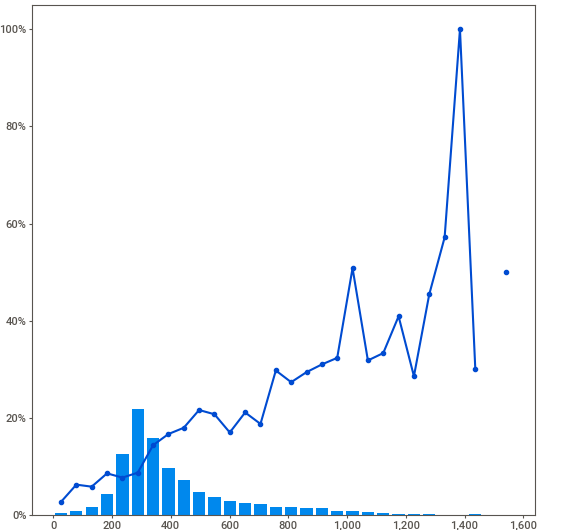
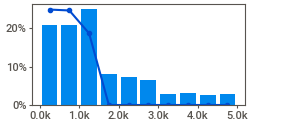
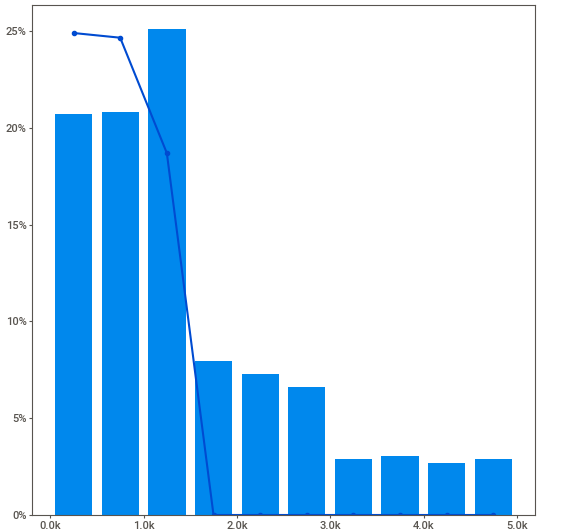
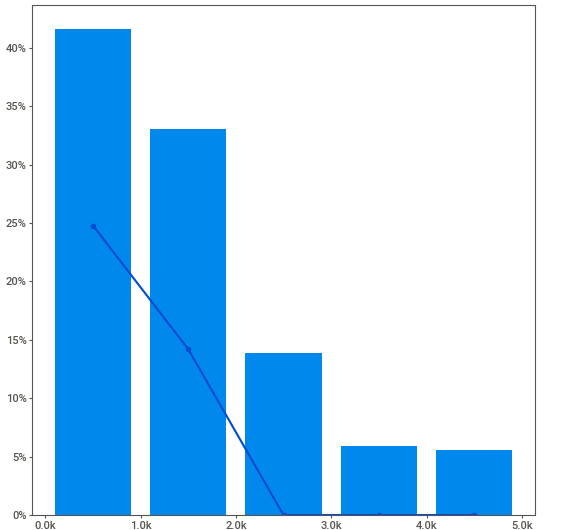
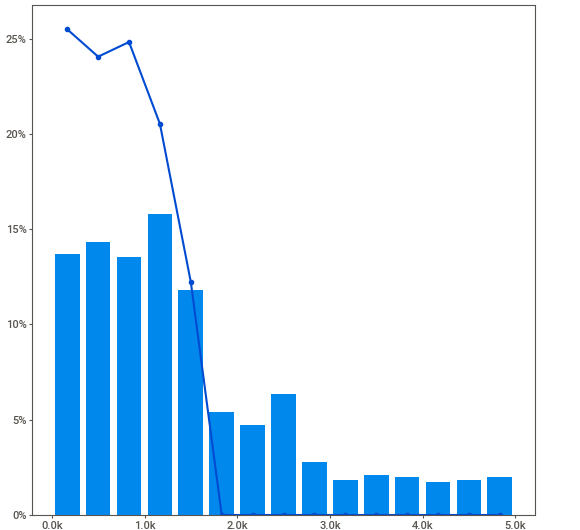
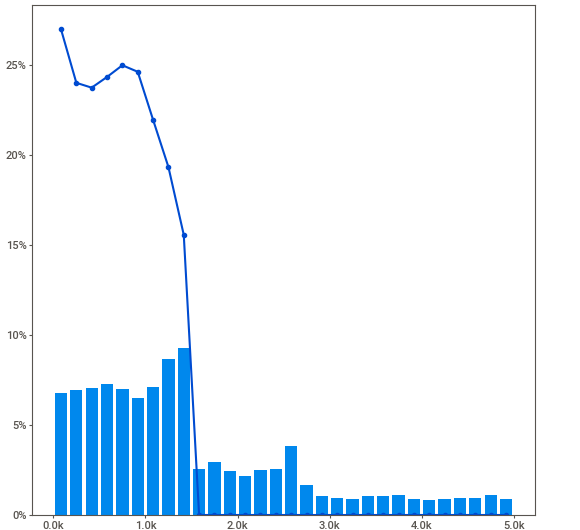
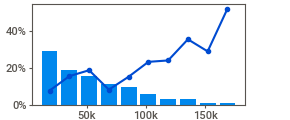
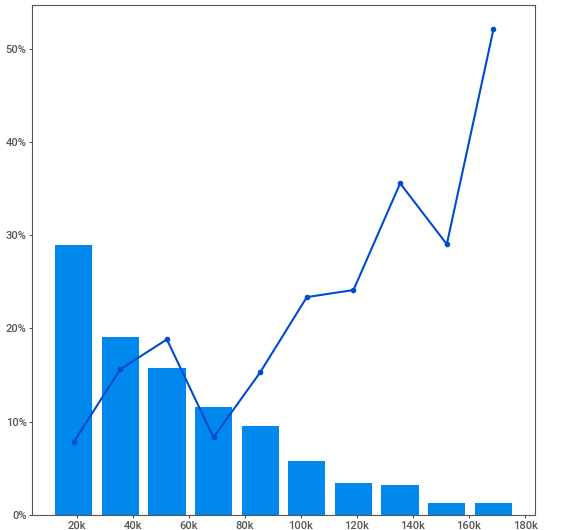
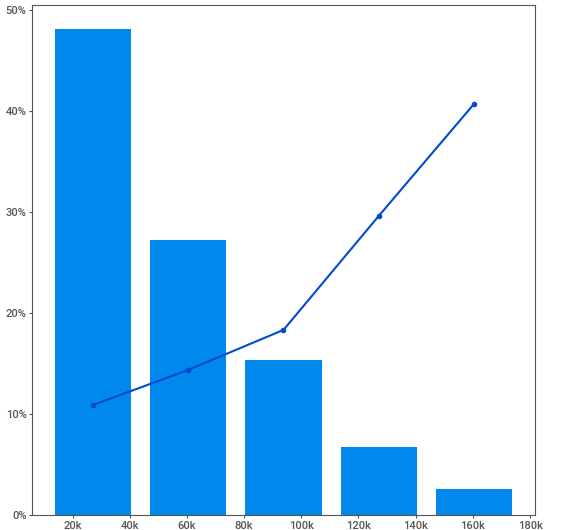
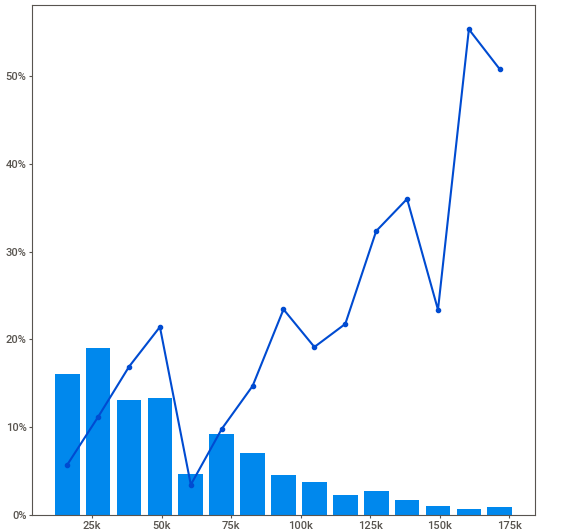
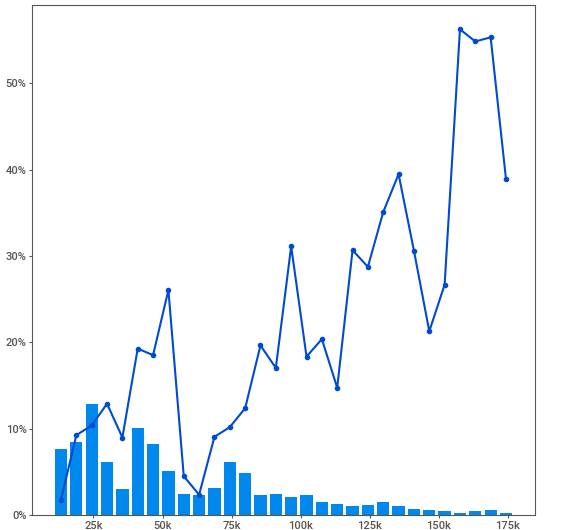
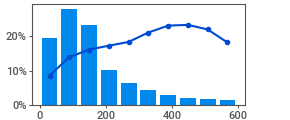
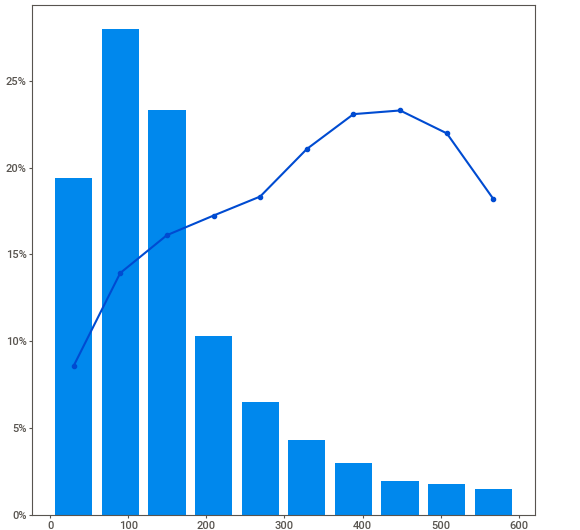
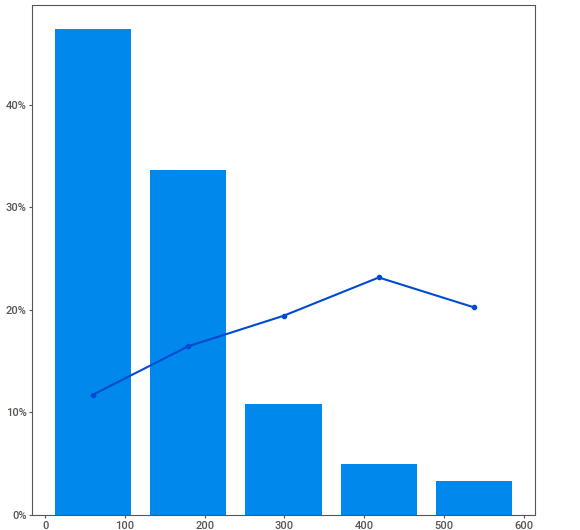
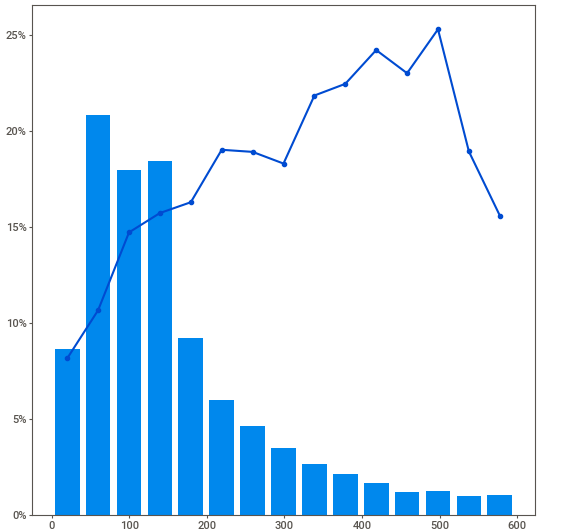
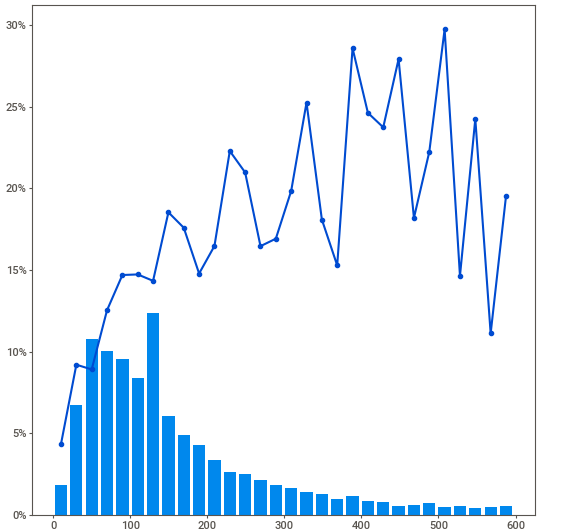
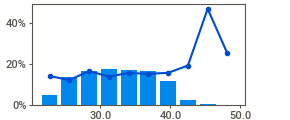
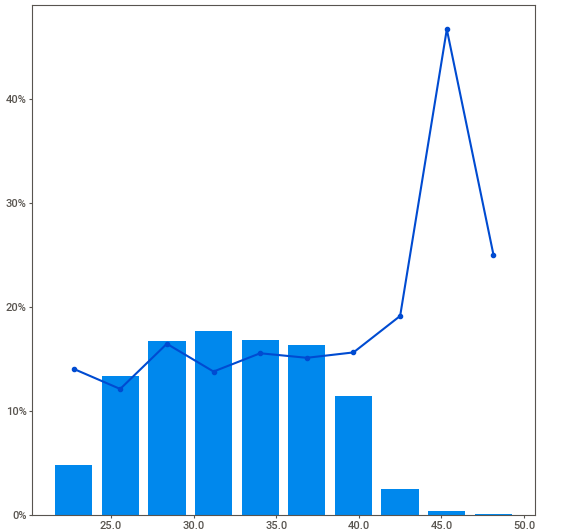
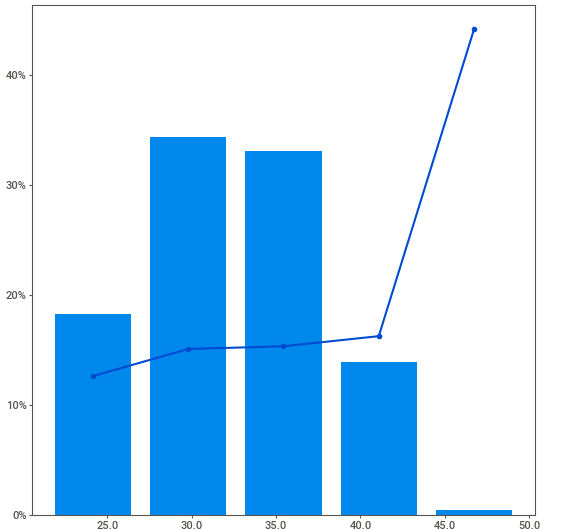
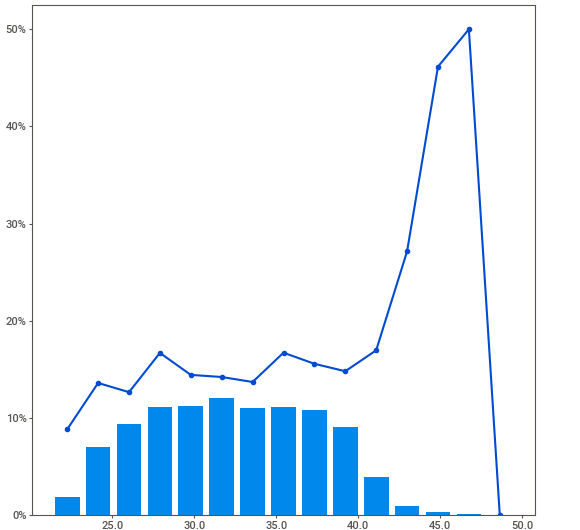
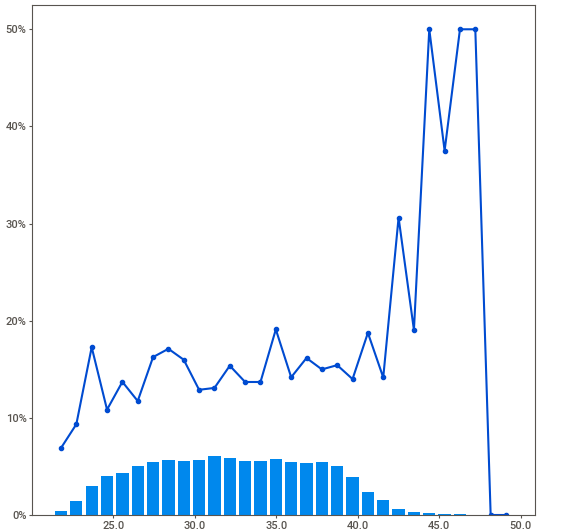
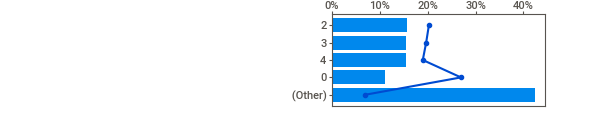
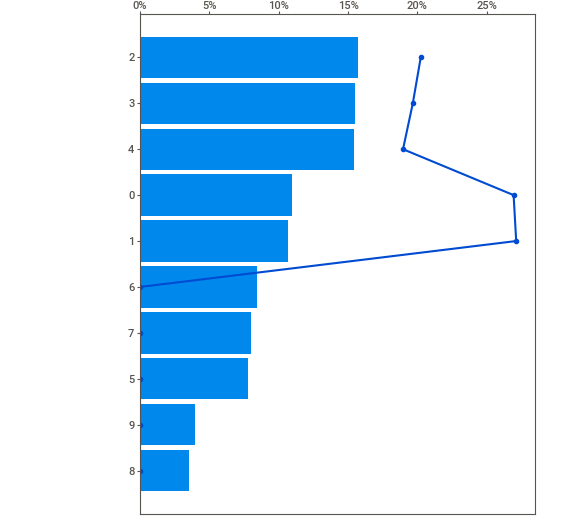
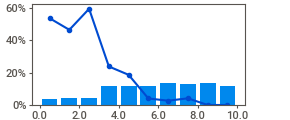
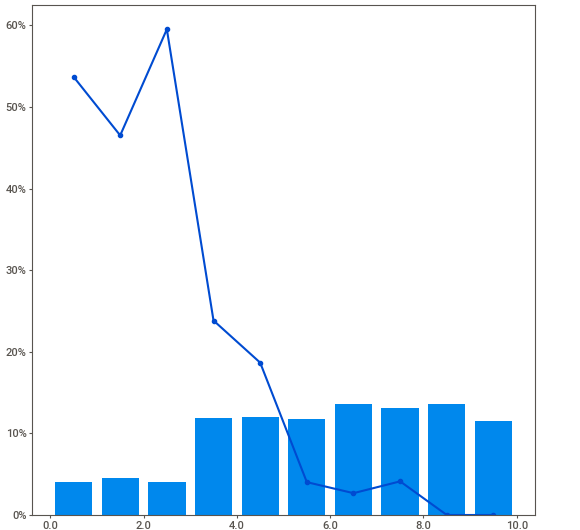
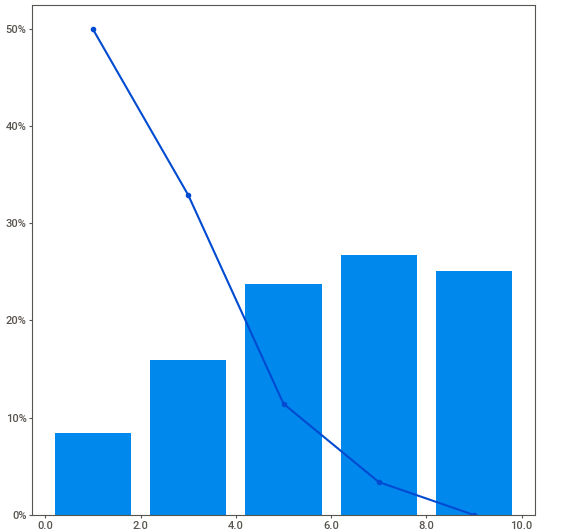
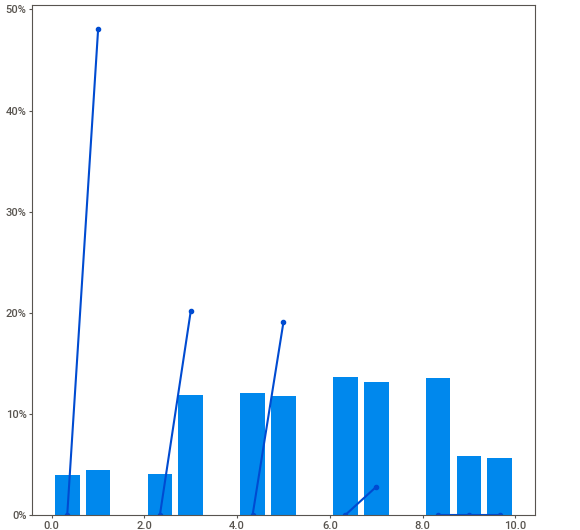
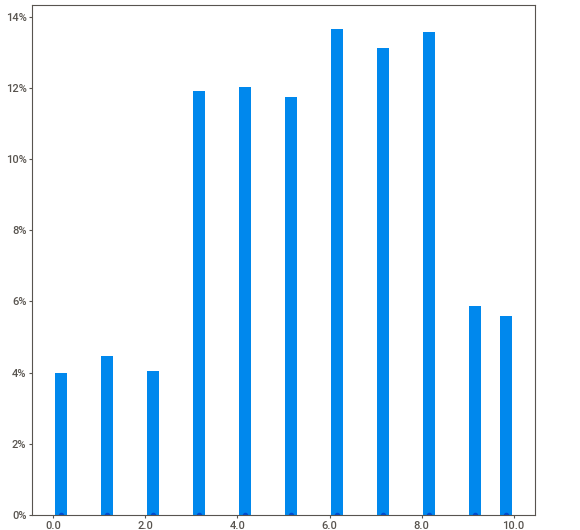
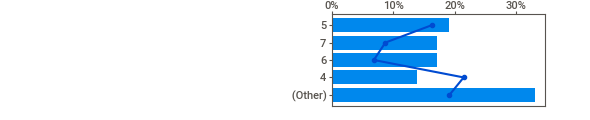
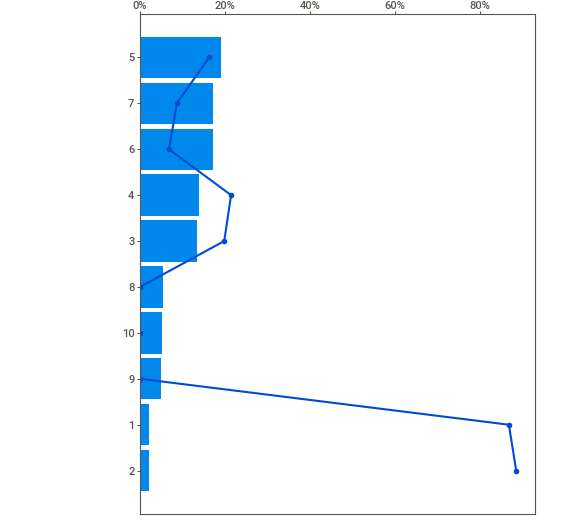
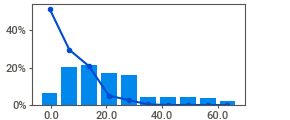
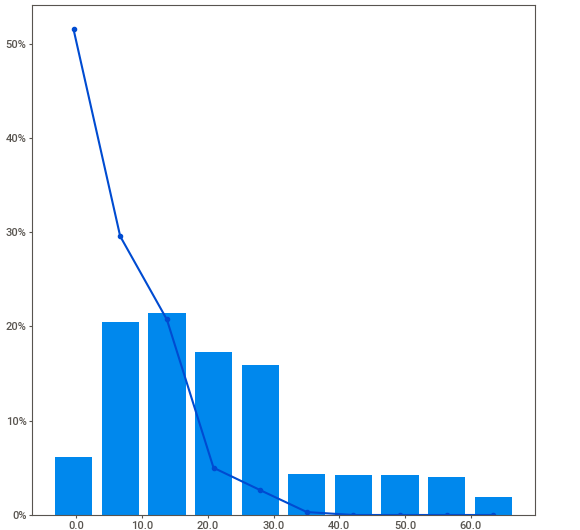
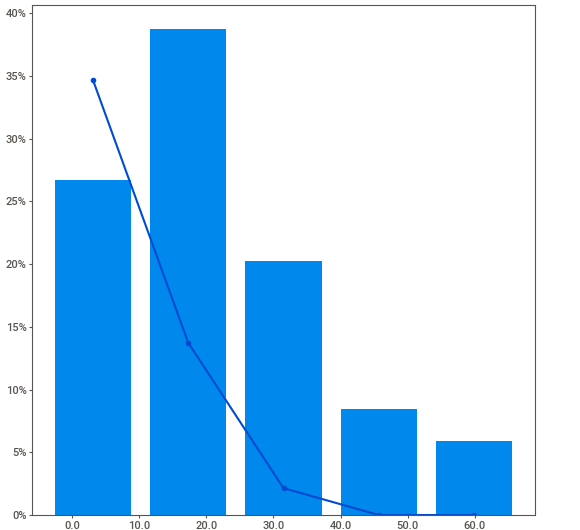
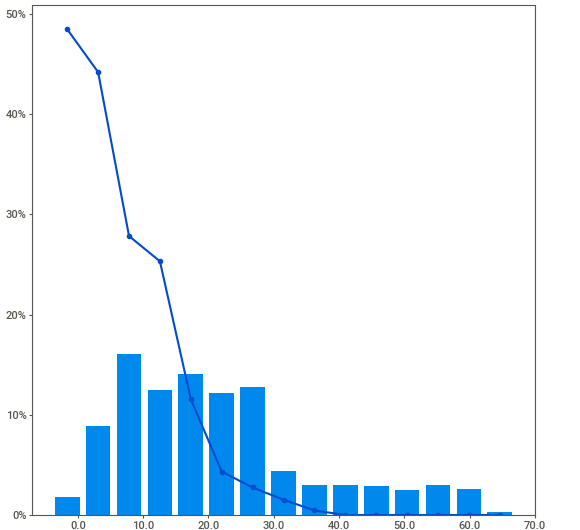
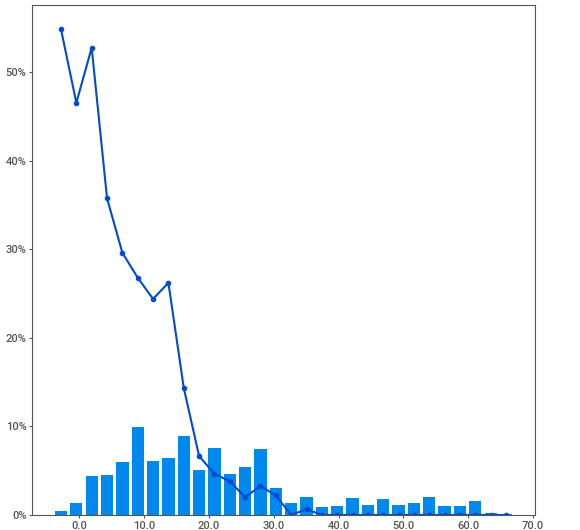
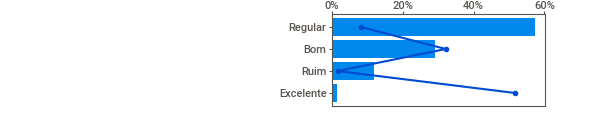
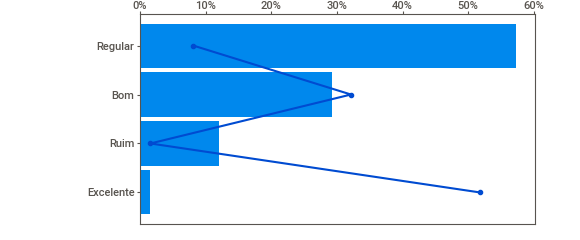
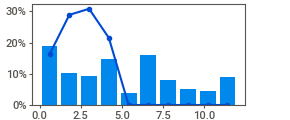
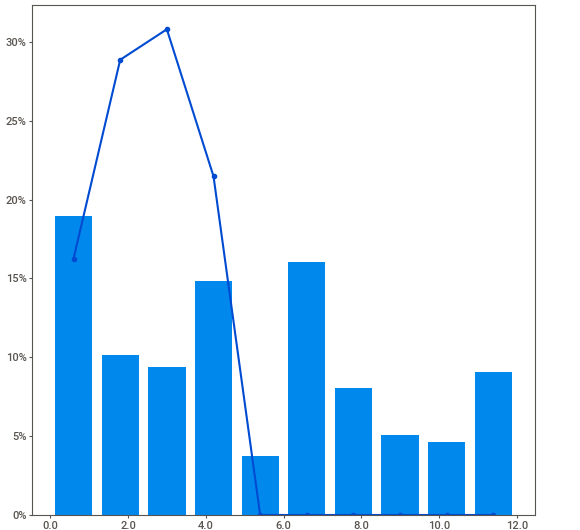
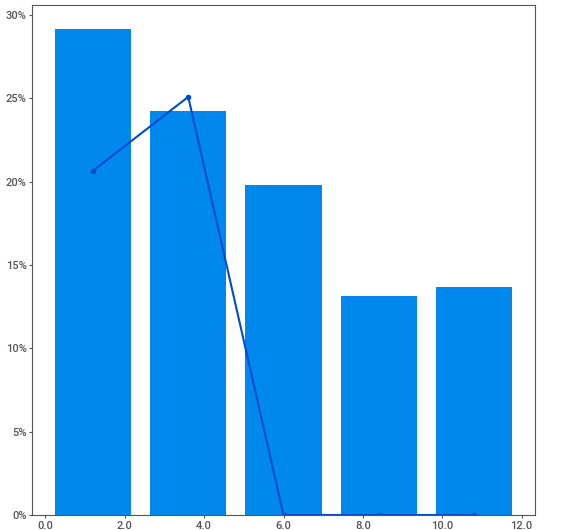
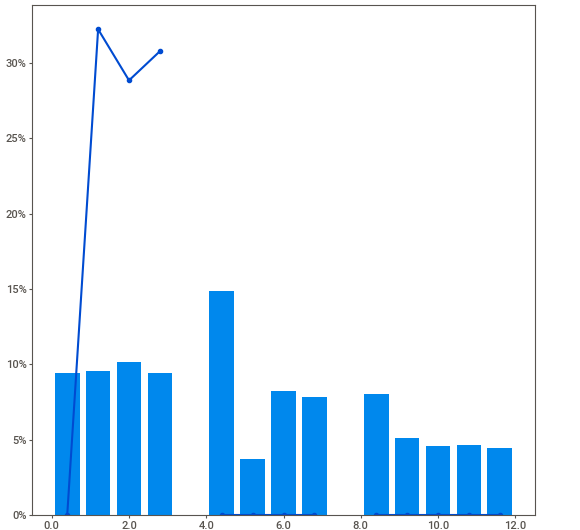
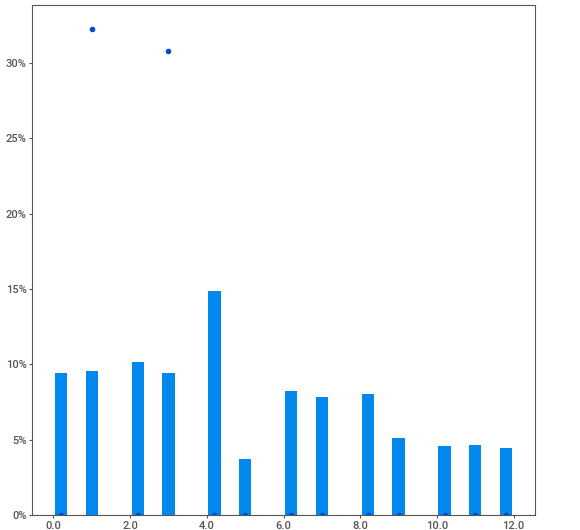
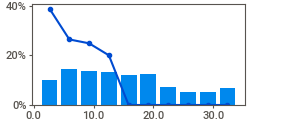
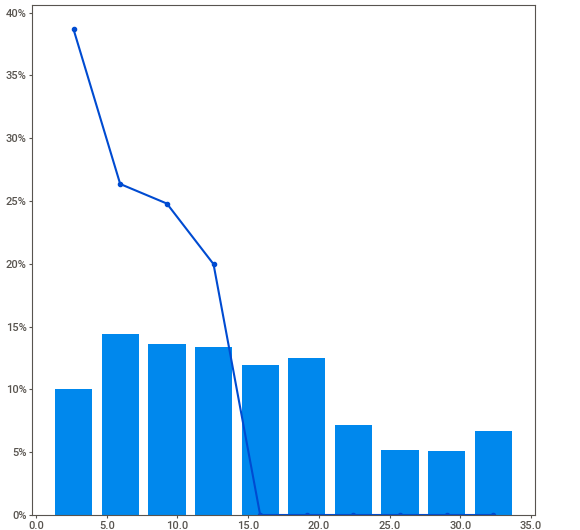
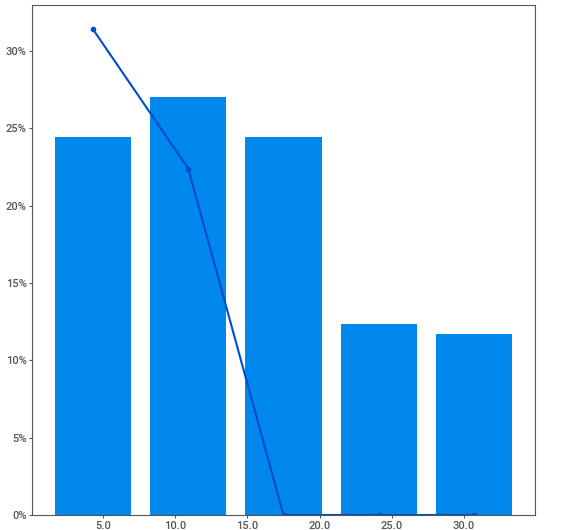
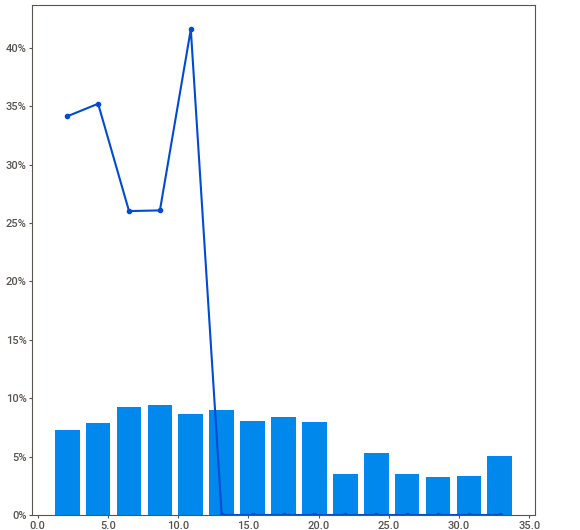
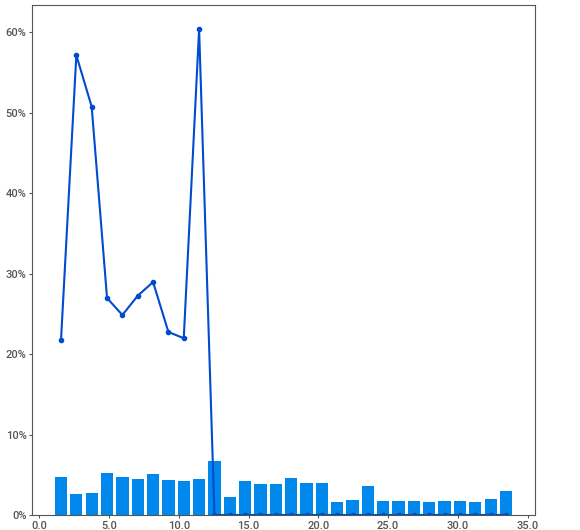
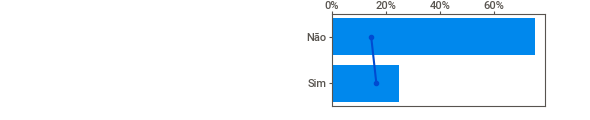
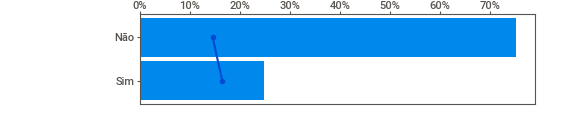
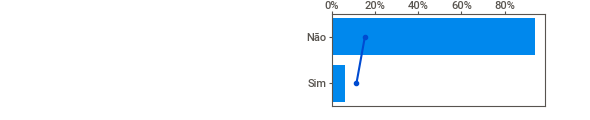
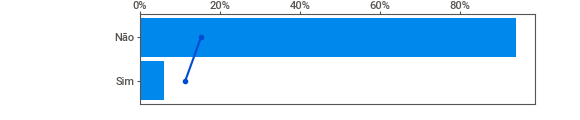
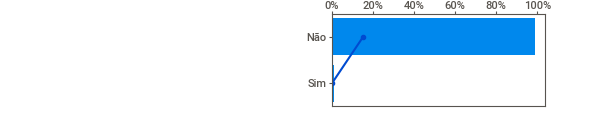
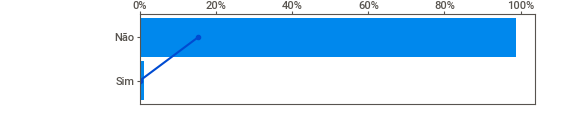
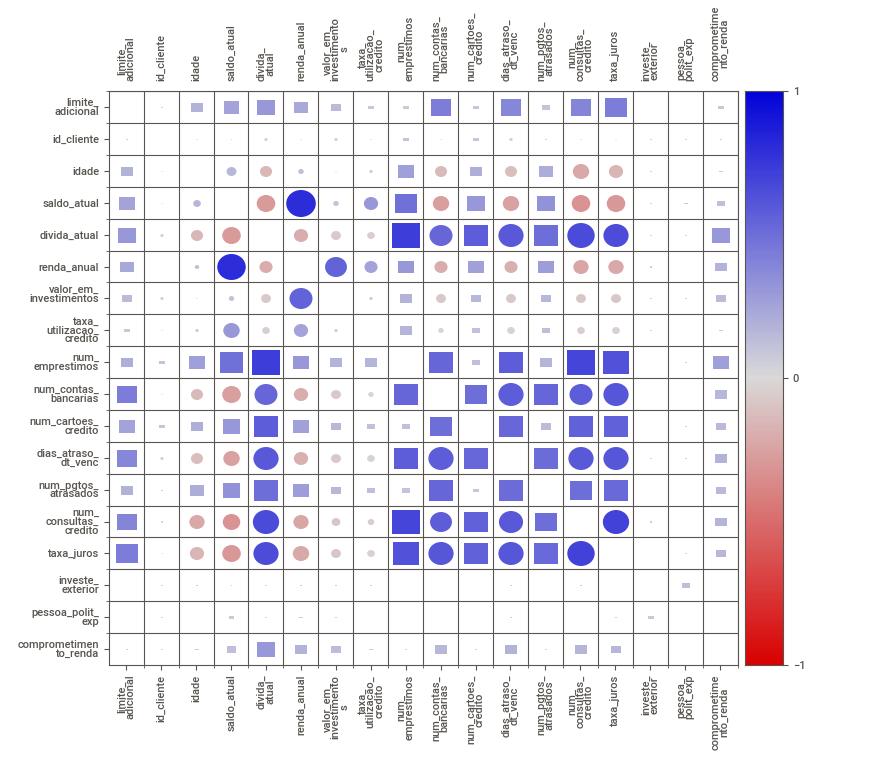
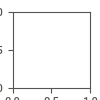

In [68]:
# Analyse Dataset
report = sweetviz.analyze(source = df3, target_feat = 'limite_adicional')
# View
report.show_notebook(w="100%", h="full") # if working in Kaggle

#### Idade

In [69]:
# idade
idade_out = df3.loc[df3['idade'] > 120]

In [70]:
# plt.plot(idade_out['idade'], 'o')

#### valor_em_investimentos

In [71]:
df3[df3["valor_em_investimentos"] > 8500].describe().T

,count,mean,std,min,25%,50%,75%,max
id_cliente,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
idade,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saldo_atual,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
divida_atual,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
renda_anual,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
valor_em_investimentos,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
taxa_utilizacao_credito,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_emprestimos,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_contas_bancarias,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_cartoes_credito,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### taxa_juros

In [72]:
df3['taxa_juros'].nunique()

34

In [73]:
taxa_juros_cat = df3['taxa_juros'].astype(object).value_counts().reset_index()

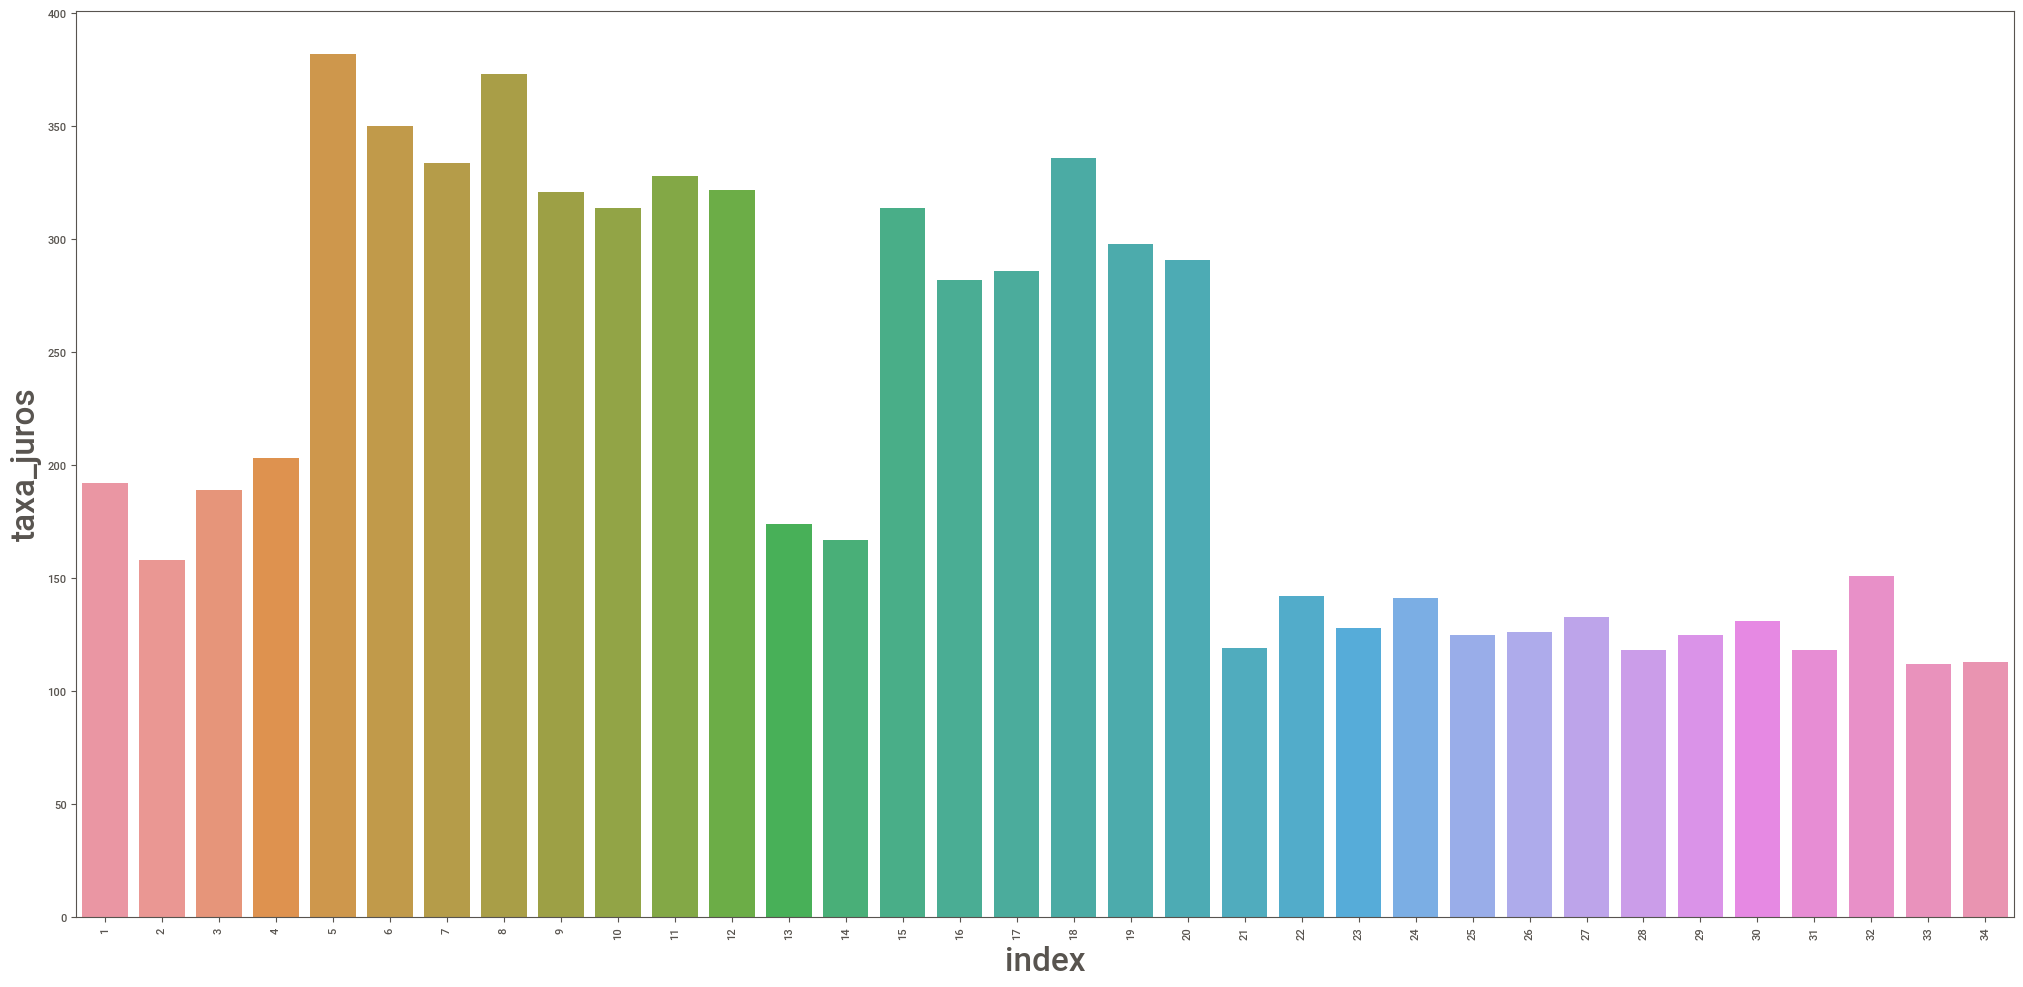

In [74]:
sns.barplot(x='index', y='taxa_juros', data=taxa_juros_cat)
plt.xticks(rotation=90)

plt.show()

#### num_emprestimos

In [75]:
df3['num_emprestimos'].nunique()

10

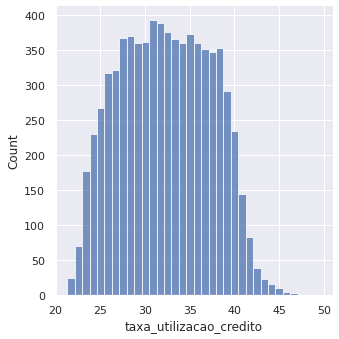

In [88]:
sns.displot(df3['taxa_utilizacao_credito'])

## 3.2. Análise Bivariada

## 3.3. Análise Multivariada

In [76]:
num_attributes = df3.select_dtypes(include=['int64', 'float64'])

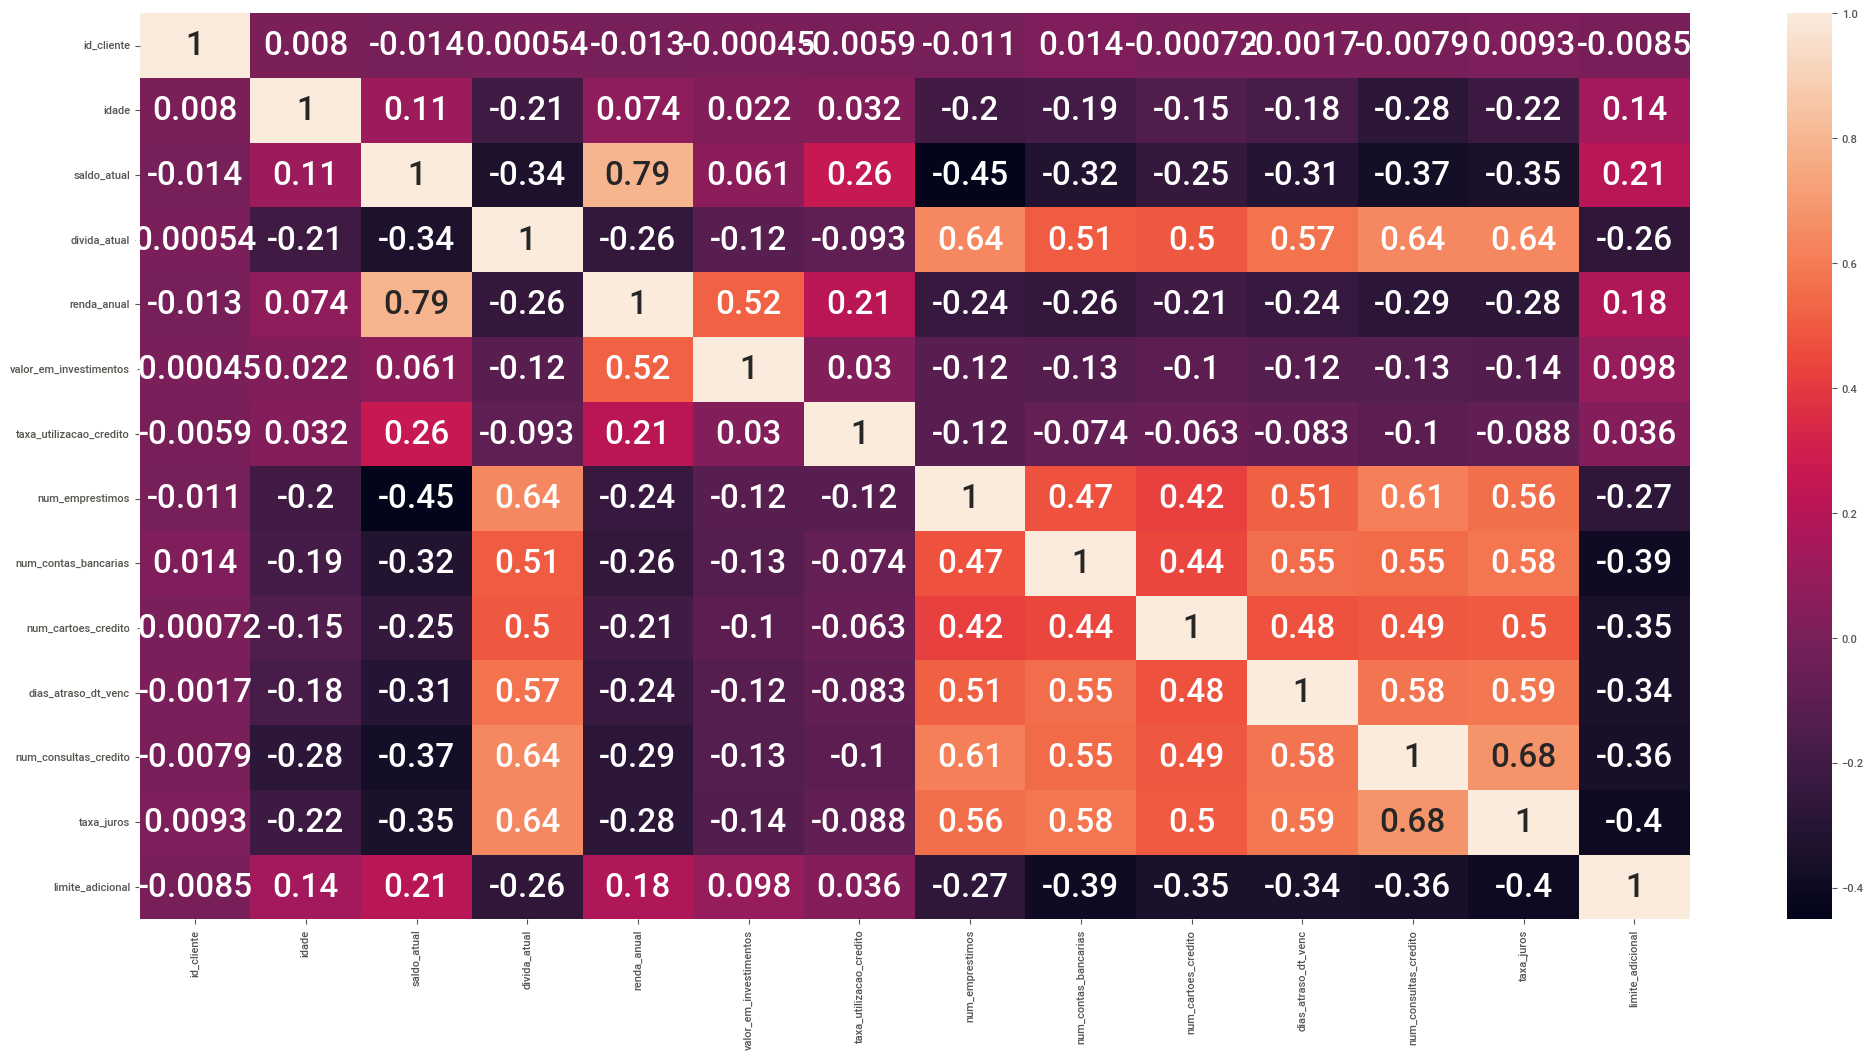

In [77]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

# 4.0. Data Preparation

In [78]:
df4 = df3.copy()

## 4.1. Normalization

In [ ]:
ss = StandardScaler()

# saldo_autal
df4['saldo_atual'] = ss.fit_transform( df4[['saldo_atual']].values )

## 4.2. Rescaling

## 4.3. Encoding